In [1]:
import torch
import clip
import os
from torchvision.datasets import  MNIST, FGVCAircraft
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet50
from torchvision.datasets import CIFAR100, StanfordCars
from torch.utils.data import DataLoader

In [5]:
#Test on datasets of CLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('RN50', device, download_root='/shareddata/clip/')

@torch.no_grad()
def accuracy(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size).item())
    return res


@torch.no_grad()
def extract_text_features(dataset_name):
    # code borrowed from: https://github.com/openai/CLIP/blob/fcab8b6eb92af684e7ff0a904464be7b99b49b88/notebooks/Prompt_Engineering_for_ImageNet.ipynb
    class_names = class_map[dataset_name]
    templates = template_map[dataset_name]
    model.to(device)
    model.eval()

    zeroshot_weights = []
    for classname in class_names:
        texts = [template.format(classname) for template in templates]
        texts = clip.tokenize(texts).to(device)
        class_embeddings = model.encode_text(texts)
        class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
        class_embedding = class_embeddings.mean(dim=0)
        class_embedding /= class_embedding.norm()
        zeroshot_weights.append(class_embedding)
    zeroshot_weights = torch.stack(zeroshot_weights, dim=1).to(device)
    return zeroshot_weights

mnist = MNIST(root=os.path.expanduser("~/.cache"), train=False)
# cifar100 = CIFAR100(root='./data', train=False)

objectnet_classes = ['bed', 'bench', 'book', 'bottle', 'bowl', 'cellphone', 'chair', 'clock', 'couch', 'remote']

# from https://github.com/openai/CLIP/blob/main/data/prompts.md
mnist_classes = ['0','1','2','3','4','5','6','7','8','9',]
mnist_classes = mnist.classes
mnist_templates = ['a photo of the number: "{}".',]
# cifar100_templates = [
#     'a photo of a {}.',
#     'a blurry photo of a {}.',
#     'a black and white photo of a {}.',
#     'a low contrast photo of a {}.',
#     'a high contrast photo of a {}.',
#     'a bad photo of a {}.',
#     'a good photo of a {}.',
#     'a photo of a small {}.',
#     'a photo of a big {}.',
#     'a photo of the {}.',
#     'a blurry photo of the {}.',
#     'a black and white photo of the {}.',
#     'a low contrast photo of the {}.',
#     'a high contrast photo of the {}.',
#     'a bad photo of the {}.',
#     'a good photo of the {}.',
#     'a photo of the small {}.',
#     'a photo of the big {}.',
# ]


class_map = {'MNIST': mnist_classes}
# class_map = {'CIFAR100':cifar100_classes}
template_map = {'MNIST': mnist_templates}
# template_map = {'CIFAR100':cifar100_templates}

for dataset in [mnist]:
# for dataset in [cifar100]:
    # extract image feature, code borrowed from: https://github.com/openai/CLIP#zero-shot-prediction
    image_features = []
    image_labels = []
    for image, class_id in dataset:
        image_input = preprocess(image).unsqueeze(0).to(device)
        with torch.no_grad():
            image_feature = model.encode_image(image_input)
        image_feature /= image_feature.norm()
        image_features.append(image_feature)
        image_labels.append(class_id)
    image_features = torch.stack(image_features, dim=1).to(device)
    image_features = image_features.squeeze()
    
    # extract text feature
#     dataset_name = 'MNIST' if dataset == mnist else 'CIFAR10'
    dataset_name = 'MNIST'
    text_features = extract_text_features(dataset_name)
    
    # compute top-1 accuracy
    logits = (100. * image_features @ text_features).softmax(dim=-1)
    image_labels = torch.tensor(image_labels).unsqueeze(dim=1).to(device)
    top1_acc = accuracy(logits, image_labels, (1,))
    print(f'top-1 accuracy for {dataset_name} dataset: {top1_acc[0]:.3f}')

top-1 accuracy for MNIST dataset: 49.360


In [5]:
#test on the FGVCAircraft
#The form of the dataset is different from the dataset above
import os
import torch
from torchvision.datasets import FGVCAircraft
import clip

# Load CLIP model and preprocessing function
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('RN50', device, download_root='/shareddata/clip/')

@torch.no_grad()
def accuracy(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size).item())
    return res

@torch.no_grad()
def extract_text_features(dataset_name):
    # code borrowed from: https://github.com/openai/CLIP/blob/fcab8b6eb92af684e7ff0a904464be7b99b49b88/notebooks/Prompt_Engineering_for_ImageNet.ipynb
    class_names = class_map[dataset_name]
    templates = template_map[dataset_name]
    model.to(device)
    model.eval()

    zeroshot_weights = []
    for classname in class_names:
        texts = [template.format(classname) for template in templates]
        texts = clip.tokenize(texts).to(device)
        class_embeddings = model.encode_text(texts)
        class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
        class_embedding = class_embeddings.mean(dim=0)
        class_embedding /= class_embedding.norm()
        zeroshot_weights.append(class_embedding)
    zeroshot_weights = torch.stack(zeroshot_weights, dim=1).to(device)
    return zeroshot_weights

# FGVC-Aircraft dataset
aircraft_dataset = FGVCAircraft(root='./data', download=True,transform=preprocess)
aircraft_classes = [f'{i:03d}' for i in range(len(aircraft_dataset.classes))]

# from https://github.com/openai/CLIP/blob/main/data/prompts.md
aircraft_templates = [
    'a photo of a {}.',
    'a blurry photo of a {}.',
    'a black and white photo of a {}.',
    'a low contrast photo of a {}.',
    'a high contrast photo of a {}.',
    'a bad photo of a {}.',
    'a good photo of a {}.',
    'a photo of a small {}.',
    'a photo of a big {}.',
    'a photo of the {}.',
    'a blurry photo of the {}.',
    'a black and white photo of the {}.',
    'a low contrast photo of the {}.',
    'a high contrast photo of the {}.',
    'a bad photo of the {}.',
    'a good photo of the {}.',
    'a photo of the small {}.',
    'a photo of the big {}.',
]

class_map = {'FGVCAircraft': aircraft_classes}
template_map = {'FGVCAircraft': aircraft_templates}

# Create a DataLoader to iterate over the dataset
data_loader = torch.utils.data.DataLoader(aircraft_dataset, batch_size=1, shuffle=False)

# Iterate over the dataset
image_features = []
image_labels = []

for image, class_id in data_loader:
    image=image.to(device)  # Convert PIL.Image.Image to torch.Tensor
    with torch.no_grad():
        image_feature = model.encode_image(image)
    image_feature /= image_feature.norm()
    image_features.append(image_feature)
    image_labels.append(class_id.item())  # Assuming class_id is a tensor

image_features = torch.stack(image_features, dim=1).to(device)
image_features = image_features.squeeze()

# Extract text features
dataset_name = 'FGVCAircraft'
text_features = extract_text_features(dataset_name)

# Compute top-1 accuracy
logits = (100. * image_features @ text_features).softmax(dim=-1)
image_labels = torch.tensor(image_labels).unsqueeze(dim=1).to(device)
top1_acc = accuracy(logits, image_labels, (1,))
print(f'top-1 accuracy for {dataset_name} dataset: {top1_acc[0]:.3f}')


top-1 accuracy for FGVCAircraft dataset: 1.230


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('RN50', device, download_root='/shareddata/clip/')
image = preprocess(Image.open("course.jpeg")).unsqueeze(0).to(device)
# text = clip.tokenize(["library", "coffee shop", "museum"]).to(device)
# text = clip.tokenize(["windows computer", "apple computer", "mobile phone"]).to(device)
# text = clip.tokenize(["maths course", "cs course", "Englishcourse"]).to(device)
text = clip.tokenize(["china course", "japan course", "koreacourse"]).to(device)
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)

Label probs: [[0.03102 0.01881 0.95   ]]


In [8]:
import os
import clip
import torch
from torchvision.datasets import CIFAR100

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-L/14@336px', device, download_root='/shareddata/clip/')

# Download the dataset
cifar100 = CIFAR100(root='./data', train=False)

# Prepare the inputs
image, class_id = cifar100[500]
image_input = preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")


Top predictions:

        elephant: 79.10%
           camel: 9.01%
        kangaroo: 1.36%
        dinosaur: 0.71%
    pickup_truck: 0.54%


In [6]:
cifar100.classes[class_id]

'elephant'

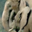

In [7]:
image

In [5]:
import os
import clip
import torch

import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
from tqdm import tqdm

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('RN50', device, download_root='/shareddata/clip/')

# Load the dataset
root='./data'
# train = CIFAR100(root, download=True, train=True, transform=preprocess)
# test = CIFAR100(root, download=True, train=False, transform=preprocess)
train = MNIST(root=os.path.expanduser("~/.cache"), train=False,transform=preprocess)
test = MNIST(root=os.path.expanduser("~/.cache"), train=True,transform=preprocess)


def get_features(dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

# Calculate the image features
train_features, train_labels = get_features(train)
test_features, test_labels = get_features(test)

# Perform logistic regression
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
classifier.fit(train_features, train_labels)

# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
print(f"Accuracy = {accuracy:.3f}")

100%|██████████| 600/600 [01:50<00:00,  5.43it/s]


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10250     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30259D+04    |proj g|=  2.19927D+02


 This problem is unconstrained.



At iterate   50    f=  8.81384D+03    |proj g|=  3.32679D+01

At iterate  100    f=  8.78793D+03    |proj g|=  1.95125D+01

At iterate  150    f=  8.78575D+03    |proj g|=  4.77433D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10250    160    170      1     0     0   8.598D-02   8.786D+03
  F =   8785.7417279542806     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Accuracy = 91.872


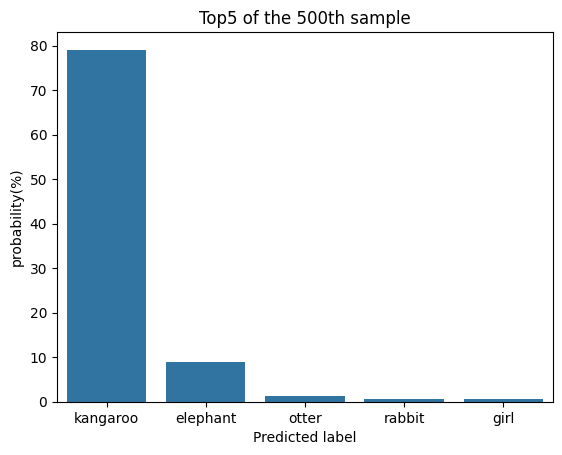

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data
# categories = ['shrew', 'flatfish', 'rabbit', 'porcupine','mouse']
# values = [13.50, 11.37, 3.58, 3.47,3.01]
categories = ['kangaroo', 'elephant', 'otter', 'rabbit','girl']
values = [79.10, 9.01, 1.36, 0.71,0.54]

# Create a bar plot using Seaborn
sns.barplot(x=categories, y=values)

# Add labels and title
plt.xlabel('Predicted label')
plt.ylabel('probability(%)')
plt.title('Top5 of the 500th sample')

# Show the plot
plt.show()